In [ ]:
import py3dep
import rasterio
from rasterio.transform import from_bounds
import numpy as np


In [ ]:
import matplotlib.pyplot as plt
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from queue import PriorityQueue
import gpxpy
import gpxpy.gpx

In [ ]:
def plot_slopes(slope_data, transform):
  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(10, 10))

  # Plot the slope data
  cax = ax.imshow(slope_data, cmap='terrain', extent=(transform[2], transform[2] + transform[0] * slope_data.shape[1], transform[5] + transform[4] * slope_data.shape[0], transform[5]))
  ax.set_title('Slope Data Visualization')
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

  # Add a colorbar
  cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink=0.75)
  cbar.set_label('Slope (degrees)')

  # Show the plot
  plt.show()

In [ ]:
# Function to calculate slope
def calculate_slope(elevation_array, resolution):
    dx, dy = np.gradient(elevation_array, resolution, resolution)
    slope = np.sqrt(dx**2 + dy**2)
    slope_degrees = np.arctan(slope) * (180 / np.pi)
    return slope_degrees

def download_slopes(start, goal, resolution, margin, file_name):
  # Define the bounding box
  min_lat = min(start[0], goal[0]) - margin
  max_lat = max(start[0], goal[0]) + margin
  min_lon = min(start[1], goal[1]) - margin
  max_lon = max(start[1], goal[1]) + margin

  # Generate coordinates for the bounding box
  xcoords = np.linspace(min_lon, max_lon, int((max_lon - min_lon) / (resolution * 1e-5)))
  ycoords = np.linspace(min_lat, max_lat, int((max_lat - min_lat) / (resolution * 1e-5)))

  # Fetch elevation data using py3dep
  elevation_data = py3dep.elevation_bygrid(
      xcoords=xcoords,
      ycoords=ycoords,
      crs="EPSG:4326",
      resolution=resolution,
      depression_filling=False
  )

  # Convert the elevation data to a 2D NumPy array
  elevation_array = np.array(elevation_data).reshape((len(ycoords), len(xcoords)))


  # Calculate the slope
  slope_data = calculate_slope(elevation_array, resolution)

  # Define the GeoTIFF transform
  transform = from_bounds(min_lon, min_lat, max_lon, max_lat, slope_data.shape[1], slope_data.shape[0])

  # Define the metadata for the GeoTIFF
  metadata = {
      'driver': 'GTiff',
      'height': slope_data.shape[0],
      'width': slope_data.shape[1],
      'count': 1,
      'dtype': slope_data.dtype,
      'crs': 'EPSG:4326',
      'transform': transform
  }

  # Save the slope data as a GeoTIFF file
  with rasterio.open(file_name, 'w', **metadata) as dst:
      dst.write(slope_data, 1)

  print(f"Slope data saved as '{file_name}'.")

In [ ]:
# Function to load slope data from the GeoTIFF file
def load_slope_data_from_file(filename):
    with rasterio.open(filename) as src:
        slope_data = src.read(1)  # Read the first band
        transform = src.transform
    return slope_data, transform

In [ ]:

# Helper functions for A* pathfinding
from scipy.ndimage import generic_filter
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def get_neighbors(node, shape):
    neighbors = [
        (node[0] - 1, node[1]), (node[0] + 1, node[1]),
        (node[0], node[1] - 1), (node[0], node[1] + 1),
        (node[0] - 1, node[1] - 1), (node[0] + 1, node[1] + 1),
        (node[0] - 1, node[1] + 1), (node[0] + 1, node[1] - 1)
    ]
    return [(r, c) for r, c in neighbors if 0 <= r < shape[0] and 0 <= c < shape[1]]


def get_neighbors_efficient(node, shape, slope_data, slope_threshold=2.0):
    def slope_difference(values):
        center = values[4]  # The center value in a 3x3 grid
        differences = np.abs(values - center)
        return np.min(differences[differences > 0]) if np.any(differences > 0) else 0

    # Calculate slope differences
    slope_diffs = generic_filter(
        slope_data, slope_difference, size=3, mode='constant', cval=np.inf)

    # Get potential neighbors
    neighbors = [
        (node[0] - 1, node[1]), (node[0] + 1, node[1]),
        (node[0], node[1] - 1), (node[0], node[1] + 1),
        (node[0] - 1, node[1] - 1), (node[0] + 1, node[1] + 1),
        (node[0] - 1, node[1] + 1), (node[0] + 1, node[1] - 1)
    ]

    # Filter neighbors based on validity and slope difference
    valid_neighbors = []
    for r, c in neighbors:
        if 0 <= r < shape[0] and 0 <= c < shape[1]:
            if slope_diffs[r, c] >= slope_threshold:
                valid_neighbors.append((r, c))
            elif not valid_neighbors or slope_data[r, c] < slope_data[valid_neighbors[-1]]:
                # Replace the last added neighbor if this one has a lower slope
                if valid_neighbors:
                    valid_neighbors.pop()
                valid_neighbors.append((r, c))

    return valid_neighbors

def a_star_search(start, goal, margin, resolution, slope_data):
    min_lat = min(start[0], goal[0]) - margin
    min_lon = min(goal[1], goal[1]) - margin

    start_idx = (int((start[0] - min_lat) / (resolution * 1e-5)), int((start[1] - min_lon) / (resolution * 1e-5)))
    goal_idx = (int((goal[0] - min_lat) / (resolution * 1e-5)), int((goal[1] - min_lon) / (resolution * 1e-5)))

    frontier = PriorityQueue()
    frontier.put((0, start_idx))
    came_from = {}
    cost_so_far = {}
    came_from[start_idx] = None
    cost_so_far[start_idx] = 0
    while not frontier.empty():
        current = frontier.get()[1]

        if current == goal_idx:
            break

        for neighbor in get_neighbors(current, slope_data.shape):
            slope = slope_data[neighbor]
            
            slope_cost = slope + 1e-6  # Ensure slope cost is always positive

            # Apply a non-linear penalty if slope exceeds 10% (which is about 5.71 degrees)
            if slope > 5.71:
              base_weight = 10
              exponent = 4
              slope_cost += base_weight * ((slope - 5.71) ** exponent)

            distance_penalty = 3000
              # Encourage horizontal and diagonal movements to create switchbacks
            movement_cost = 1 # if neighbor[0] == current[0] or neighbor[1] == current[1] else 1.414  # 1.414 is sqrt(2) for diagonal movement
            new_cost = cost_so_far[current] + slope_cost * movement_cost + \
                distance_penalty * movement_cost  # Add the slope as the cost

            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost + heuristic(goal_idx, neighbor)
                frontier.put((priority, neighbor))
                came_from[neighbor] = current

    if goal_idx not in came_from:
        print("Goal not reachable")
        return []

    # Reconstruct path
    path = []
    current = goal_idx
    while current != start_idx:
        path.append(current)
        current = came_from[current]
    path.append(start_idx)
    path.reverse()

    return path

def path_to_coords(start, goal, margin, path, resolution):
    min_lat = min(start[0], goal[0]) - margin
    min_lon = min(start[1], goal[1]) - margin

    # Convert path indices back to coordinates
    path_coords = [(min_lat + y * (resolution * 1e-5), min_lon + x * (resolution * 1e-5)) for y, x in path]
    path_coords = np.array(path_coords)
    return path_coords


def plot_path(start, goal, path_coords, slope_data, transform):
    # Convert path indices back to coordinates

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the slope data
    cax = ax.imshow(slope_data, cmap='terrain', extent=(transform[2], transform[2] + transform[0] * slope_data.shape[1], transform[5] + transform[4] * slope_data.shape[0], transform[5]))
    ax.set_title('Slope Data Visualization with Walking Path')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot the walking path between the two points
    ax.plot(path_coords[:, 1], path_coords[:, 0], 'r-', linewidth=2, label='Walking Path')
    ax.plot(start[1], start[0], 'bo', label='Start Point')  # Point 1
    ax.plot(goal[1], goal[0], 'go', label='End Point')    # Point 2
    ax.legend()

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink=0.75)
    cbar.set_label('Slope (degrees)')

    # Show the plot
    plt.show()

* Write out the track as gpx

In [ ]:

def write_gpx_file(path_coords, filename):
  # Create GPX file
  gpx = gpxpy.gpx.GPX()
  gpx_track = gpxpy.gpx.GPXTrack()
  gpx.tracks.append(gpx_track)
  gpx_segment = gpxpy.gpx.GPXTrackSegment()
  gpx_track.segments.append(gpx_segment)

  for lat, lon in path_coords:
      gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(lat, lon))

  with open('path.gpx', 'w') as f:
      f.write(gpx.to_xml())

  print("GPX file 'path.gpx' created.")


def calculate_bounding_box(start, goal, margin):
  min_lat = min(start[0], goal[0]) - margin
  max_lat = max(start[0], goal[0]) + margin
  min_lon = min(start[1], goal[1]) - margin
  max_lon = max(start[1], goal[1]) + margin
  return (min_lat, min_lon, max_lat, max_lon)


In [ ]:
# Define the coordinates for two points and desired resolution

map_start = 40.657192271514724, -111.56876501454423  # Point 1 (e.g., New York)
# lat2, lon2 = 40.628910538489876, -111.56936207691058  # some point on wasatch crest trail
map_goal = 40.69414448717707, -111.60456091449336 # murdock peak
#map_goal = 40.6731508995287, -111.68279139021001  # gobblers knob
map_resolution = 2  # in meters

# Define the margin around the points for the bounding box (in degrees)
map_margin = 0.003  # Reduced from 0.010 to make it run much faster
map_file = 'slope_data.tif'
map_gpx_file = 'path.gpx'


In [ ]:
download_slopes(map_start, map_goal, map_resolution, map_margin, map_file)

In [ ]:
map_slope_data, map_transform = load_slope_data_from_file(map_file)
plot_slopes(map_slope_data, map_transform)

In [ ]:

# Perform A* search
path = a_star_search(start=map_start, goal=map_goal, margin=map_margin,
                     resolution=map_resolution, slope_data=map_slope_data)


In [ ]:

path_coords = path_to_coords(start = map_start, goal = map_goal, margin = map_margin, path = path, resolution = map_resolution)

plot_path(start=map_start, goal=map_goal, 
          path_coords=path_coords, slope_data=map_slope_data, transform = map_transform)
write_gpx_file(path_coords=path_coords, filename=map_gpx_file)

In [ ]:
MIDWAY = (40.536500, -111.478036)
NW_OF_GRANDEUR = (40.722394, -111.770837)

download_slopes(MIDWAY, NW_OF_GRANDEUR, map_resolution, map_margin, map_file)

In [ ]:
import py3dep
import numpy as np


def get_elevation_data(start, goal, margin, resolution, chunk_size=0.1):
    
    """Fetches elevation data in chunks using py3dep and returns a combined grid.
    Args:
        min_lat: Minimum latitude of the desired grid.
        max_lat: Maximum latitude of the desired grid.
        min_lon: Minimum longitude of the desired grid.
        max_lon: Maximum longitude of the desired grid.
        resolution: Resolution of the elevation data in arc-seconds.
        chunk_size: Size of each chunk in degrees (default: 5).
    Returns:
        A NumPy array containing the combined elevation data for the entire grid.
    """

    min_lat = min(start[0], goal[0]) - margin
    max_lat = max(start[0], goal[0]) + margin
    min_lon = min(start[1], goal[1]) - margin
    max_lon = max(start[1], goal[1]) + margin

    # Calculate chunk boundaries
    lat_chunks = np.arange(min_lat, max_lat + chunk_size, chunk_size)
    lon_chunks = np.arange(min_lon, max_lon + chunk_size, chunk_size)

    print(f"Grid Size: {len(lat_chunks)-1} x {len(lon_chunks)-1}")
    # Initialize empty array for final elevation data
    full_grid = np.zeros((len(lat_chunks)-1, len(lon_chunks)-1), dtype=object)

    # Fetch and store elevation data in chunks
    for i, lat_start in enumerate(lat_chunks[:-1]):
        for j, lon_start in enumerate(lon_chunks[:-1]):
            lat_end = lat_start + chunk_size
            lon_end = lon_start + chunk_size

            # Generate coordinates for the bounding box
            xcoords = np.linspace(lon_start, lon_end, int(
                (lon_end - lon_start) / (resolution * 1e-5)))
            ycoords = np.linspace(lat_start, lat_end, int(
                (lat_end - lat_start) / (resolution * 1e-5)))
            print(
                f"getting data for {lat_start}, {lat_end}, {lon_start}, {lon_end}")

            # Fetch elevation data using py3dep
            chunk_data = py3dep.elevation_bygrid(
                xcoords=xcoords,
                ycoords=ycoords,
                crs="EPSG:4326",
                resolution=resolution,
                depression_filling=False
            )
            if chunk_data is not None:  # Store if not empty, empty chunks will remain 0
                full_grid[i, j] = chunk_data

    # Flatten the elevation data
    elevation_data = np.block(full_grid.tolist())

    return elevation_data


MIDWAY = (40.536500, -111.478036)
NW_OF_GRANDEUR = (40.722394, -111.770837)

# Example usage with named parameters (replace with your values)
elevation_grid = get_elevation_data(start = MIDWAY, goal = NW_OF_GRANDEUR, margin = 0.01, resolution=2)

print(elevation_grid)

In [78]:
import numpy as np


def extract_slope_matrix(slope_data, center_coord, bbox_size, data_bbox):
    """
    Extract a matrix of slope points centered around the given coordinates.
    
    Parameters:
    slope_data (numpy.ndarray): 2D array of slope data
    center_coord (tuple): (latitude, longitude) of the center point
    bbox_size (int): Size of the bounding box (in data points)
    data_bbox (tuple): (min_lat, min_lon, max_lat, max_lon) of the entire slope_data
    
    Returns:
    numpy.ndarray: Matrix of slope points
    tuple: (min_lat, min_lon) of the extracted matrix
    tuple: (row, col) extraction_origin in the larger matrix
    """
    lat, lon = center_coord
    min_lat, min_lon, max_lat, max_lon = data_bbox

    # Calculate the total range of latitude and longitude
    total_lat_range = max_lat - min_lat
    total_lon_range = max_lon - min_lon

    # Calculate the resolution of the slope data
    lat_resolution = total_lat_range / slope_data.shape[0]
    lon_resolution = total_lon_range / slope_data.shape[1]

    # Find the index of the center point
    center_row = int((lat - min_lat) / lat_resolution)
    center_col = int((lon - min_lon) / lon_resolution)

    # Calculate the half-size of the bounding box
    half_size = bbox_size // 2

    # Calculate the boundaries of the extracted matrix
    min_row = max(0, center_row - half_size)
    max_row = min(slope_data.shape[0], center_row + half_size + 1)
    min_col = max(0, center_col - half_size)
    max_col = min(slope_data.shape[1], center_col + half_size + 1)

    # Extract the slope matrix
    extracted_matrix = slope_data[min_row:max_row, min_col:max_col]

    # Calculate the lat/lon of the top-left corner of the extracted matrix
    extracted_min_lat = min_lat + min_row * lat_resolution
    extracted_min_lon = min_lon + min_col * lon_resolution

    # The extraction_origin is the top-left corner of the extracted matrix in the larger matrix
    extraction_origin = (min_row, min_col)

    return extracted_matrix, (extracted_min_lat, extracted_min_lon), extraction_origin

# Example usage:
# slope_data = np.random.rand(1000, 1000)  # Example slope data
# data_bbox = (34.0, -118.5, 34.1, -118.4)  # (min_lat, min_lon, max_lat, max_lon)
# center_coord = (34.05, -118.45)
# bbox_size = 100

# extracted_slope, (min_lat, min_lon), extraction_origin = extract_slope_matrix(slope_data, center_coord, bbox_size, data_bbox)

# print(f"Extracted matrix shape: {extracted_slope.shape}")
# print(f"Top-left corner coordinates: ({min_lat}, {min_lon})")
# print(f"Extraction origin in larger matrix: {extraction_origin}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_slope_matrix_detailed(slope_matrix, title="Detailed Slope Visualization", figsize=(15, 12), max_text_display=30):
    """
    Visualize a slope matrix as a color-coded grid with small boxes.
    
    Parameters:
    slope_matrix (numpy.ndarray): 2D array of slope data
    title (str): Title for the plot
    figsize (tuple): Figure size
    max_text_display (int): Maximum size of matrix to display text values
    
    Returns:
    matplotlib.figure.Figure: The created figure object
    """
    # Round the slope values to one decimal place
    rounded_matrix = np.round(slope_matrix, decimals=1)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a color map from green to red
    cmap = sns.color_palette("YlOrRd", as_cmap=True)
    
    # Determine whether to display text in cells
    display_text = slope_matrix.shape[0] <= max_text_display and slope_matrix.shape[1] <= max_text_display
    
    # Create the heatmap
    if display_text:
        sns.heatmap(rounded_matrix, annot=True, fmt='.1f', cmap=cmap, cbar_kws={'label': 'Slope (degrees)'}, ax=ax, square=True)
    else:
        sns.heatmap(rounded_matrix, annot=False, cmap=cmap, cbar_kws={'label': 'Slope (degrees)'}, ax=ax, square=True)
    
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Remove x and y ticks for cleaner look with small grid boxes
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Invert the y-axis so that the origin is at the bottom-left
    ax.invert_yaxis()
    
    return fig

# Example usage:
# Assuming we have our slope_matrix from the previous extract_slope_matrix function

# slope_matrix, (min_lat, min_lon) = extract_slope_matrix(slope_data, center_coord, bbox_size, data_bbox)

# fig = visualize_slope_matrix_detailed(slope_matrix, title=f"Detailed Slope Visualization (Origin: {min_lat:.4f}, {min_lon:.4f})")
# plt.show()

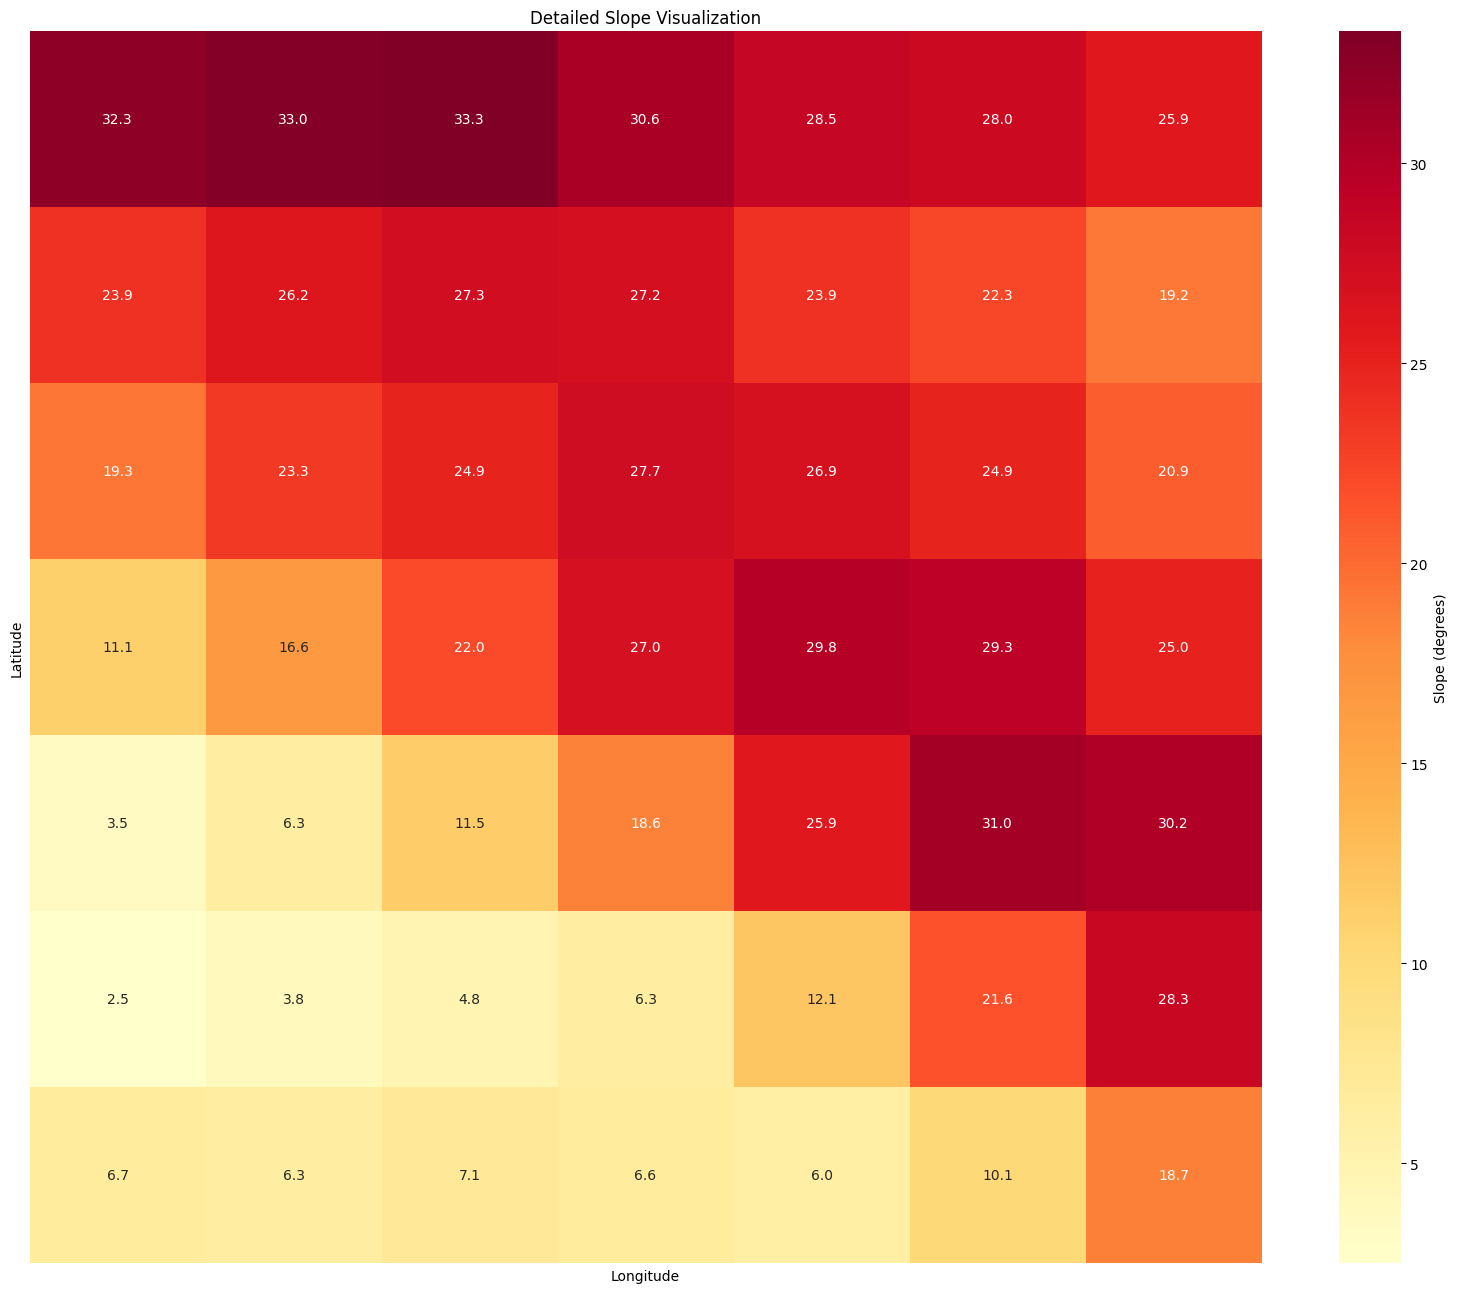

In [79]:
grid, _, extraction_origin = extract_slope_matrix(map_slope_data, map_start, 7,
                     calculate_bounding_box(map_start, map_goal, map_margin))

fig = visualize_slope_matrix_detailed(
    grid,
    title=f"Detailed Slope Visualization",
    figsize=(20, 16)  # Adjust as needed
)
plt.show()

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_extracted_slope_with_path(extracted_slope, full_path, extraction_origin, title="Extracted Slope with Path", figsize=(15, 12)):
    """
    Visualize an extracted slope matrix with the relevant part of a path from a larger matrix.
    
    Parameters:
    extracted_slope (numpy.ndarray): 2D array of extracted slope data
    full_path (list of tuples): List of (row, col) coordinates representing the full path in the larger matrix
    extraction_origin (tuple): (row, col) coordinates of the top-left corner of the extraction in the larger matrix
    title (str): Title for the plot
    figsize (tuple): Figure size
    
    Returns:
    matplotlib.figure.Figure: The created figure object
    """
    # Round the slope values to one decimal place
    rounded_matrix = np.round(extracted_slope, decimals=1)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Create a color map from green to red
    cmap = sns.color_palette("YlOrRd", as_cmap=True)

    # Manually add text annotations to every cell
    for i in range(rounded_matrix.shape[0]):
        for j in range(rounded_matrix.shape[1]):
            ax.text(j + 0.5, i + 0.5, f'{rounded_matrix[i, j]:.1f}°',
                    ha='center', va='center', color='black', fontsize=8)
            
    # Create the heatmap
    sns.heatmap(rounded_matrix, cmap=cmap, cbar_kws={'label': 'Slope (degrees)'}, ax=ax, square=True,
                linewidths=0.5, linecolor='black')

    # Filter and adjust the path for the extracted area
    extracted_path = []
    for row, col in full_path:
        adjusted_row = row - extraction_origin[0]
        adjusted_col = col - extraction_origin[1]
        if 0 <= adjusted_row < extracted_slope.shape[0] and 0 <= adjusted_col < extracted_slope.shape[1]:
            extracted_path.append((adjusted_row, adjusted_col))

    # Plot the extracted part of the path
    if extracted_path:
        path_rows, path_cols = zip(*extracted_path)
        ax.plot(np.array(path_cols) + 0.5, np.array(path_rows) + 0.5,
                color='blue', linewidth=2, marker='o', markersize=4)

        # Highlight start and end points if they're in the extracted area
        if extracted_path[0] == (path_rows[0], path_cols[0]):
            ax.plot(path_cols[0] + 0.5, path_rows[0] + 0.5,
                    color='green', marker='o', markersize=8, label='Start')
        if extracted_path[-1] == (path_rows[-1], path_cols[-1]):
            ax.plot(path_cols[-1] + 0.5, path_rows[-1] + 0.5,
                    color='red', marker='o', markersize=8, label='End')

        # Add slope labels along the path
        for row, col in extracted_path:
            slope = rounded_matrix[row, col]
            ax.text(col + 0.5, row + 0.5, f'{slope:.1f}°', ha='center', va='center',
                    color='black', fontweight='bold', fontsize=8)

        ax.legend()

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Column Index in Extracted Matrix')
    ax.set_ylabel('Row Index in Extracted Matrix')

    # Invert the y-axis so that the origin is at the top-left (matrix-style indexing)
    ax.invert_yaxis()

    return fig

# Example usage:
# Assuming we have our extracted_slope_matrix from the extract_slope_matrix function,
# a full_path from the A* algorithm on the larger matrix, and the extraction_origin

# extracted_slope_matrix, (min_lat, min_lon) = extract_slope_matrix(slope_data, center_coord, bbox_size, data_bbox)
# full_path = a_star_search(start, goal, full_slope_matrix)  # This is the path in the larger matrix
# extraction_origin = (100, 100)  # This is where the extraction starts in the larger matrix

# fig = visualize_extracted_slope_with_path(
#     extracted_slope_matrix,
#     full_path,
#     extraction_origin,
#     title=f"Extracted Slope with A* Path (Origin: {min_lat:.4f}, {min_lon:.4f})",
#     figsize=(15, 12)
# )
# plt.show()

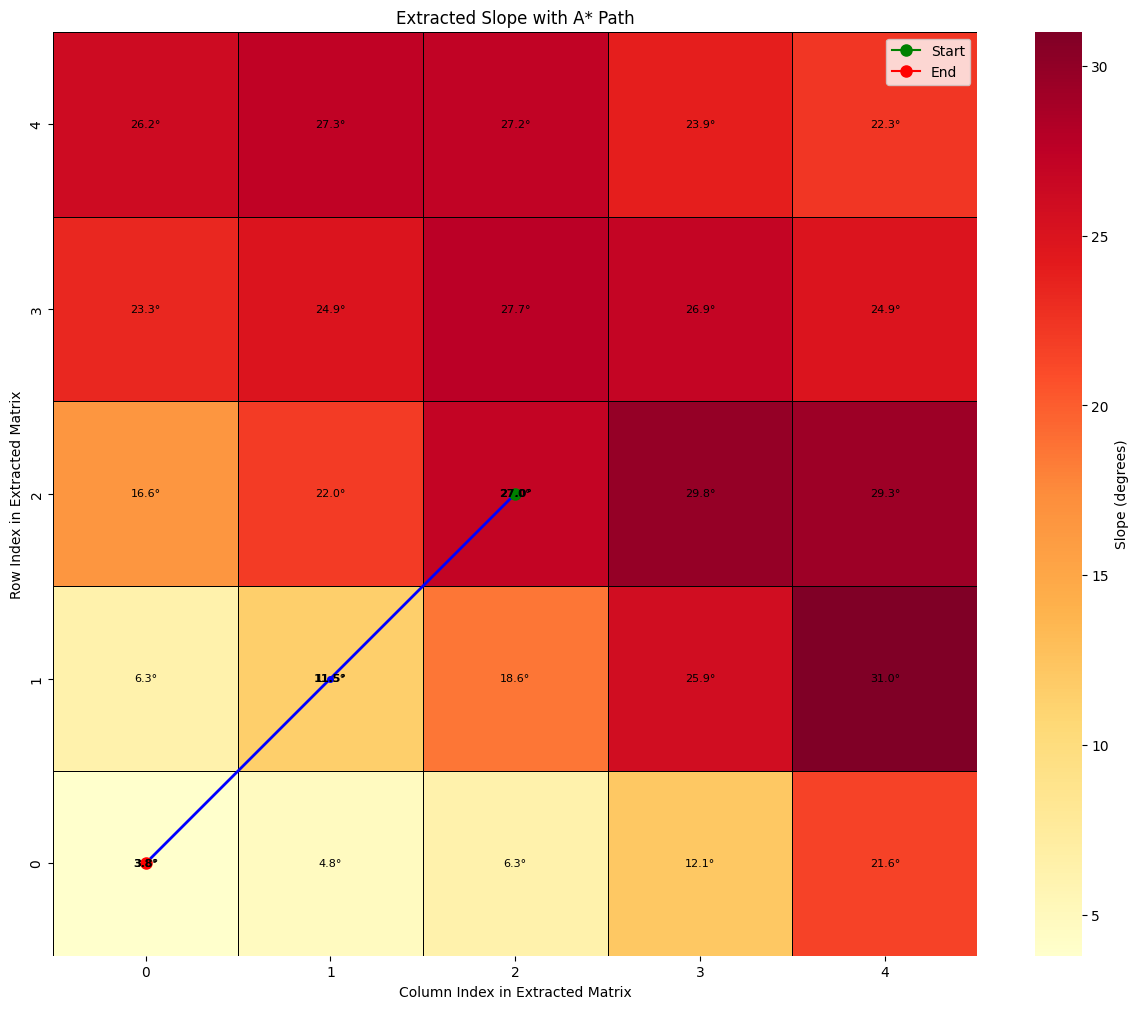

In [88]:
grid, _, extraction_origin = extract_slope_matrix(map_slope_data, map_start, 5,
                               calculate_bounding_box(map_start, map_goal, map_margin))

fig = visualize_extracted_slope_with_path(
    grid,
    path,
    extraction_origin,
    title=f"Extracted Slope with A* Path",
    figsize=(15, 12)
)
plt.show()